<a href="https://colab.research.google.com/github/nvkaimak/Bank/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 19.9 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
import statsmodels.tsa.api as smt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sktime.utils.plotting import plot_series
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import DecisionTreeRegressor

ModuleNotFoundError: No module named 'sktime'

# Read data

In [6]:
data_train = pd.read_excel('train.xlsm',header=None, ).iloc[:,0].str.split(',',expand=True)
data_train.columns = data_train.iloc[0]
data_train.drop(labels = [0],axis = 0, inplace = True)
data_train.replace('',np.NaN,inplace = True)

data_test = pd.read_excel('test.xlsm',header=None).iloc[:,0].str.split(',',expand=True)
data_test.columns = data_test.iloc[0]
data_test.drop(labels = [0],axis = 0, inplace = True)
data_test.replace('',np.NaN,inplace = True)

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 1 to 549
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DT      549 non-null    object
 1   f1      545 non-null    object
 2   f2      545 non-null    object
 3   f3      549 non-null    object
 4   f4      549 non-null    object
 5   f5      547 non-null    object
 6   f6      546 non-null    object
 7   f7      549 non-null    object
 8   f8      547 non-null    object
 9   f9      548 non-null    object
 10  f10     548 non-null    object
 11  f11     546 non-null    object
 12  f12     549 non-null    object
 13  t13     549 non-null    object
dtypes: object(14)
memory usage: 60.2+ KB


In [8]:
data_train.head()

,DT,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,t13
1,2021-12-31 20:00:00,-0.47810919408,0.04243600000000001,2,12156.0,0.11,0.096,1.75,0.17,0.588,5.71,0.53,2021-12-31 20:00:00,90.18070516053211
2,2022-01-01 08:00:00,-0.471832141920744,0.08468100000000002,2,12111.0,0.2,0.091,1.77,0.167,0.523,4.87,0.55,2022-01-01 08:00:00,92.07281985233575
3,2022-01-01 20:00:00,-0.5510543188195702,0.128881,3,13173.0,0.24,0.119,1.62,0.196,0.534,4.7,0.66,2022-01-01 20:00:00,88.72172776281076
4,2022-01-02 08:00:00,-0.5653525002597519,0.060516,4,13390.0,0.136,0.11,1.65,0.202,0.569,4.78,0.65,2022-01-02 08:00:00,90.42985143771696
5,2022-01-02 20:00:00,-0.5757142601798486,0.07182400000000001,1,13518.0,0.136,0.132,1.73,0.202,0.572,4.79,0.66,2022-01-02 20:00:00,91.40999958843572


In [9]:
data_train[data_train.drop(columns = ['DT','f12']).columns] = data_train[data_train.drop(columns = ['DT','f12']).columns].astype(float)
data_test[data_test.drop(columns = ['DT','f12']).columns] = data_test[data_test.drop(columns = ['DT','f12']).columns].astype(float)

In [10]:
data_train['f12'] = data_train['f12'].astype("datetime64[ns]")
data_test['f12'] = data_test['f12'].astype("datetime64[ns]")

In [11]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 1 to 549
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DT      549 non-null    object        
 1   f1      545 non-null    float64       
 2   f2      545 non-null    float64       
 3   f3      549 non-null    float64       
 4   f4      549 non-null    float64       
 5   f5      547 non-null    float64       
 6   f6      546 non-null    float64       
 7   f7      549 non-null    float64       
 8   f8      547 non-null    float64       
 9   f9      548 non-null    float64       
 10  f10     548 non-null    float64       
 11  f11     546 non-null    float64       
 12  f12     549 non-null    datetime64[ns]
 13  t13     549 non-null    float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 60.2+ KB


# EDA

In [818]:
data_train.head()

,DT,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,t13
1,2021-12-31 20:00:00,-0.478109,0.042436,2.0,12156.0,0.110,0.096,1.75,0.170,0.588,5.71,0.53,2021-12-31 20:00:00,90.180705
2,2022-01-01 08:00:00,-0.471832,0.084681,2.0,12111.0,0.200,0.091,1.77,0.167,0.523,4.87,0.55,2022-01-01 08:00:00,92.072820
3,2022-01-01 20:00:00,-0.551054,0.128881,3.0,13173.0,0.240,0.119,1.62,0.196,0.534,4.70,0.66,2022-01-01 20:00:00,88.721728
4,2022-01-02 08:00:00,-0.565353,0.060516,4.0,13390.0,0.136,0.110,1.65,0.202,0.569,4.78,0.65,2022-01-02 08:00:00,90.429851
5,2022-01-02 20:00:00,-0.575714,0.071824,1.0,13518.0,0.136,0.132,1.73,0.202,0.572,4.79,0.66,2022-01-02 20:00:00,91.410000


In [819]:
data_train.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,t13
count,545.000000,545.000000,549.000000,549.000000,547.000000,546.000000,549.000000,547.000000,548.000000,548.000000,546.000000,549.000000
mean,-0.544771,0.184932,2.996357,12367.464481,0.263104,0.147651,1.490729,0.133846,0.446090,5.347405,0.669322,89.847214
std,0.385792,0.132170,1.432160,2018.250796,0.112379,0.047787,0.117205,0.040825,0.327121,0.672125,0.159909,1.485929
min,-6.211515,0.026471,1.000000,1079.000000,0.100000,0.009700,1.100000,0.039000,0.170000,0.523000,0.040800,83.325466
25%,-0.549883,0.106276,2.000000,12659.000000,0.196000,0.112000,1.420000,0.104000,0.390000,5.040000,0.560000,88.943366
50%,-0.467212,0.152881,3.000000,13133.000000,0.239000,0.138000,1.500000,0.123000,0.412000,5.290000,0.640000,89.921936
75%,-0.443799,0.220853,4.000000,13322.000000,0.306000,0.177000,1.590000,0.160000,0.434000,5.582500,0.770000,90.871468
max,-0.420003,1.123600,5.000000,13803.000000,0.910000,0.301000,1.770000,0.299000,3.830000,10.060000,1.210000,93.694813


## Анализ пропущенных значений.

In [820]:
data_train.isna().sum()

0
DT     0
f1     4
f2     4
f3     0
f4     0
f5     2
f6     3
f7     0
f8     2
f9     1
f10    1
f11    3
f12    0
t13    0
dtype: int64

In [821]:
print(f'''
  В данных отсутствуют значения в следующих признаках : f1, f2, f5, f6, f8, f9, f10, f11.
  Общий процент пропусков: {round(100*data_train.isna().sum().sum()/data_train.shape[0],1)} %.''')


  В данных отсутствуют значения в следующих признаках : f1, f2, f5, f6, f8, f9, f10, f11.
  Общий процент пропусков: 3.6 %.


При дальнейшем построении модели - будет использоваться 2 набора данных:
*   1-ый набор - так как процент пропуска относительно небольшой, первый набор будет содерджать данные без учета пропусков
* 2-ой набор - с заполнением пропусков.

## Выбросы

<ipython-input-822-423a8d59a417>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot (3, 4, 1)


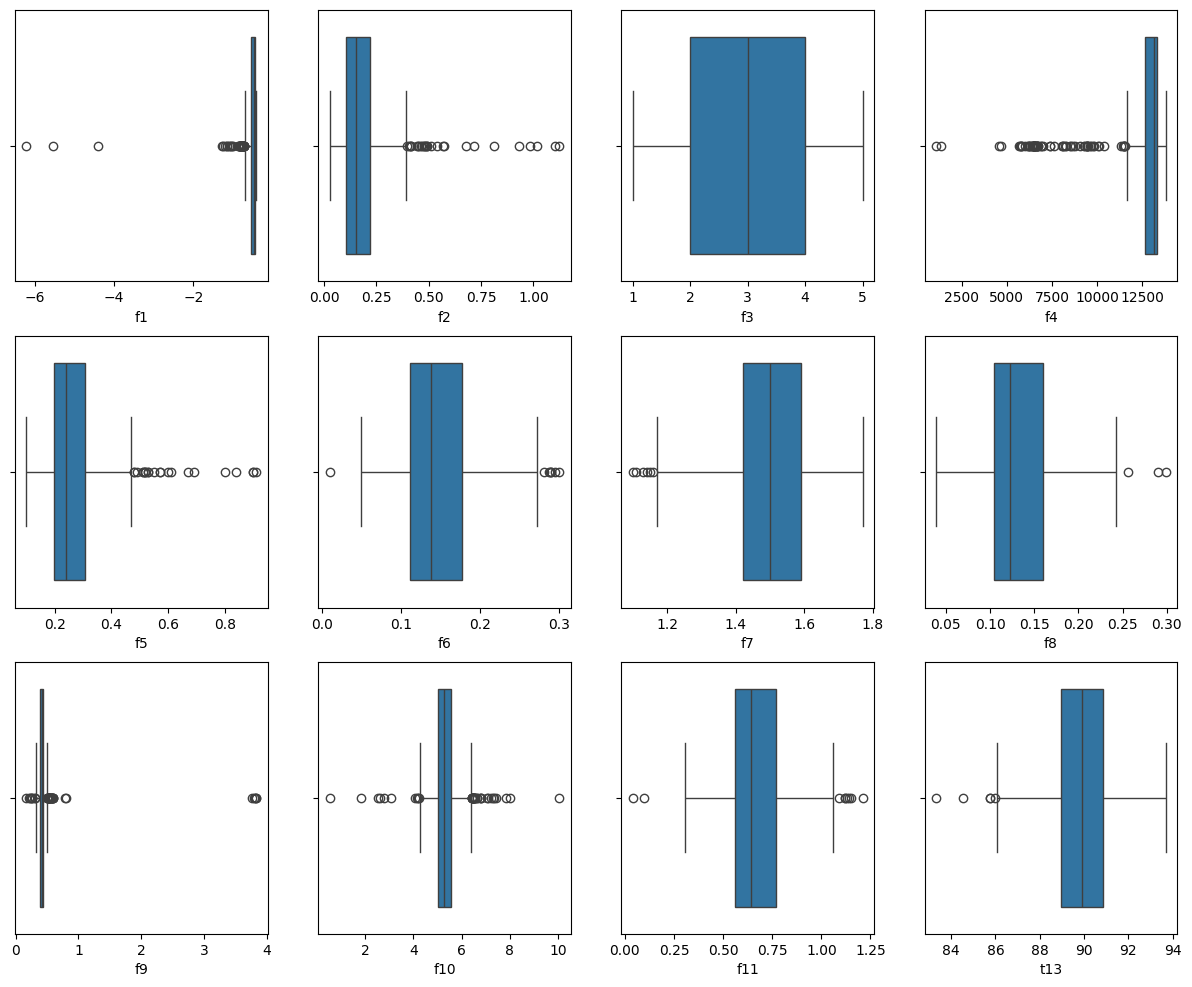

In [822]:
fig, ax = plt.subplots(figsize=(15, 12))
plt.subplot (3, 4, 1)
sns.boxplot(x=data_train.iloc[:,1])
plt.subplot (3, 4, 2)
sns.boxplot(x=data_train.iloc[:,2])
plt.subplot (3, 4, 3)
sns.boxplot(x=data_train.iloc[:,3])
plt.subplot (3, 4, 4)
sns.boxplot(x=data_train.iloc[:,4])

plt.subplot (3, 4, 5)
sns.boxplot(x=data_train.iloc[:,5])
plt.subplot (3, 4, 6)
sns.boxplot(x=data_train.iloc[:,6])
plt.subplot (3, 4, 7)
sns.boxplot(x=data_train.iloc[:,7])
plt.subplot (3, 4, 8)
sns.boxplot(x=data_train.iloc[:,8])

plt.subplot (3, 4, 9)
sns.boxplot(x=data_train.iloc[:,9])
plt.subplot (3, 4, 10)
sns.boxplot(x=data_train.iloc[:,10])
plt.subplot (3, 4, 11)
sns.boxplot(x=data_train.iloc[:,11])
plt.subplot (3, 4, 12)
sns.boxplot(x=data_train.iloc[:,13])
plt.show()


Из графика видны сильные выбросы во многих признаках, но так как нет информации о природе признаков, на данный момент считать их действительно выбросами или ошибками в данных не целесообразно, поэтому оставим данные как есть.

## Корреляция

<Axes: xlabel='0', ylabel='0'>

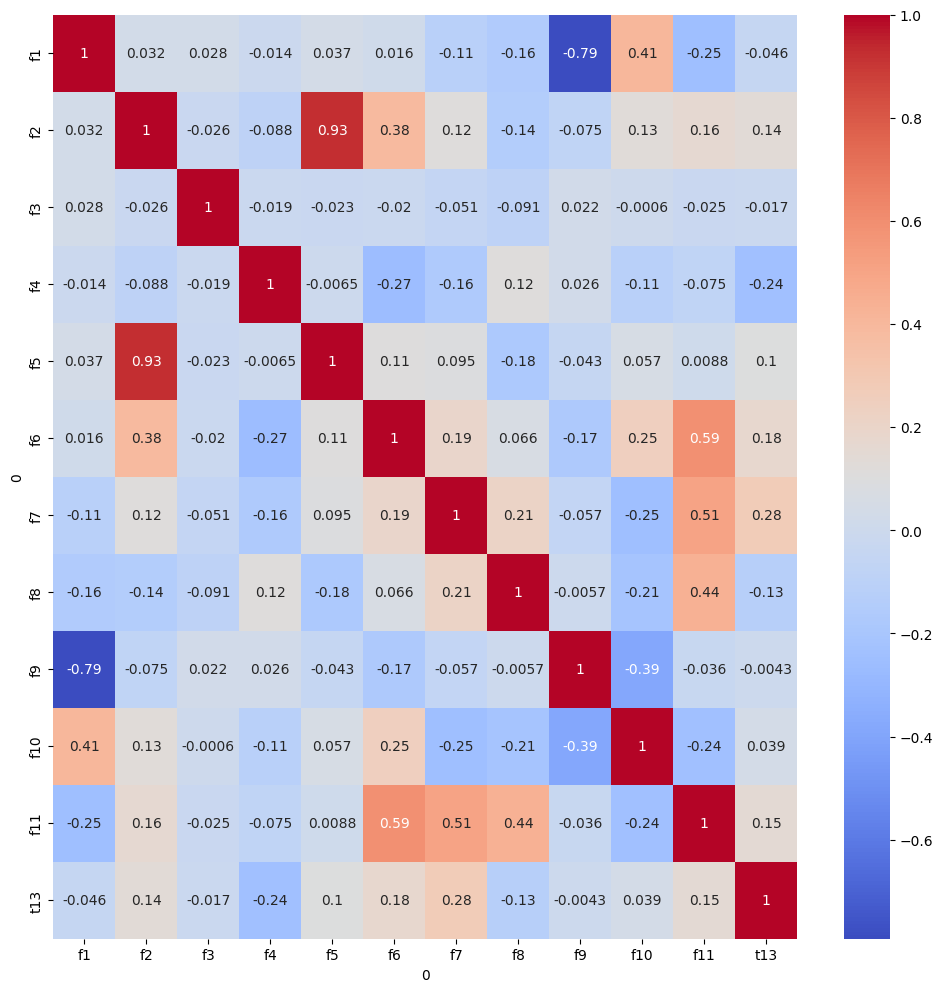

In [823]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(data_train.loc[:,data_train.dtypes == 'float64'].corr(), annot = True, cmap= 'coolwarm')

Мы видим, что признаки 'f2' и 'f5' сильно коррелируют между собой. Можно оставить только 1 из них. Например 'f2', так как у него больше пропущенных значений. Также признак 'f9' имеет слабую корреляцию с целевой переменной.

## Временной ряд

In [824]:
data_train['f12'].unique ()[:30]

array(['2021-12-31T20:00:00.000000000', '2022-01-01T08:00:00.000000000',
       '2022-01-01T20:00:00.000000000', '2022-01-02T08:00:00.000000000',
       '2022-01-02T20:00:00.000000000', '2022-01-03T08:00:00.000000000',
       '2022-01-03T20:00:00.000000000', '2022-01-04T08:00:00.000000000',
       '2022-01-04T20:00:00.000000000', '2022-01-05T08:00:00.000000000',
       '2022-01-05T20:00:00.000000000', '2022-01-06T08:00:00.000000000',
       '2022-01-06T20:00:00.000000000', '2022-01-07T08:00:00.000000000',
       '2022-01-07T20:00:00.000000000', '2022-01-08T08:00:00.000000000',
       '2022-01-08T20:00:00.000000000', '2022-01-09T08:00:00.000000000',
       '2022-01-09T20:00:00.000000000', '2022-01-10T08:00:00.000000000',
       '2022-01-10T20:00:00.000000000', '2022-01-11T08:00:00.000000000',
       '2022-01-11T20:00:00.000000000', '2022-01-12T08:00:00.000000000',
       '2022-01-12T20:00:00.000000000', '2022-01-13T08:00:00.000000000',
       '2022-01-13T20:00:00.000000000', '2022-01-14

Мы видим,что данные даны на каждый день на утро и на вечер. Можно извлечь дополнительную информацию - месяц,будни/выходные, день недели,утро/вечер.

In [825]:
data_date_morning = data_train.loc[data_train['f12'].dt.hour==8,['t13','f12']].set_index('f12')
data_date_morning.index = pd.to_datetime(data_date_morning.index)
data_date_evening = data_train.loc[data_train['f12'].dt.hour==20,['t13','f12']].set_index('f12')


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='t13'>)

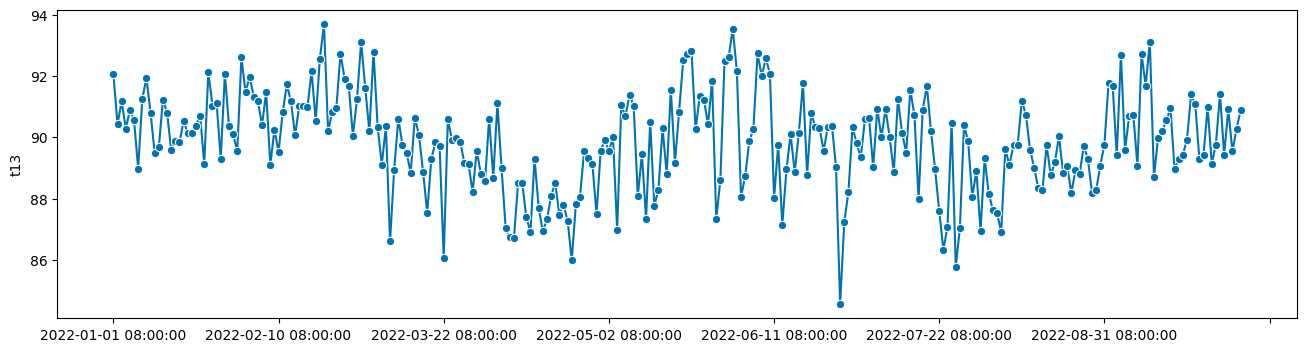

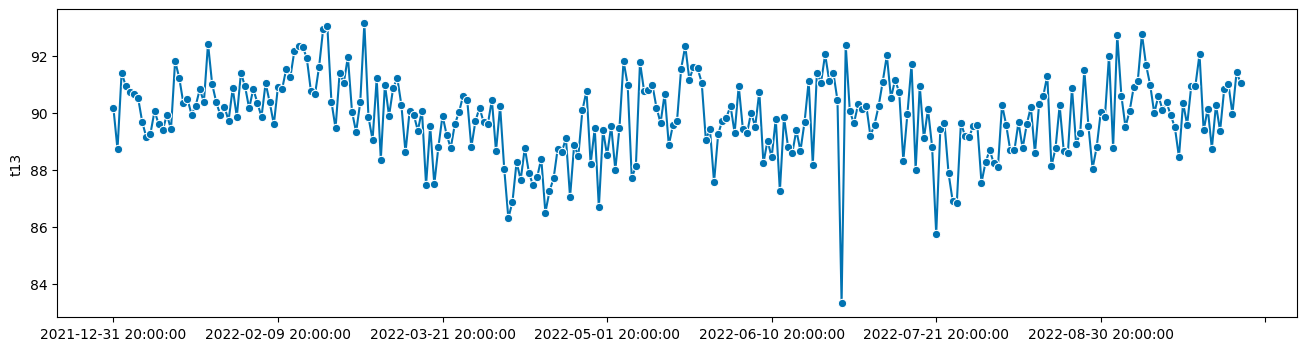

In [826]:
plot_series(data_date_morning['t13'])
plot_series(data_date_evening['t13'])

Визуально целевая переменная утром и вечером ведет себя практически одинаково.

In [878]:
data_date = data_train[['t13','f12']].set_index('f12')

<Figure size 1500x2000 with 0 Axes>

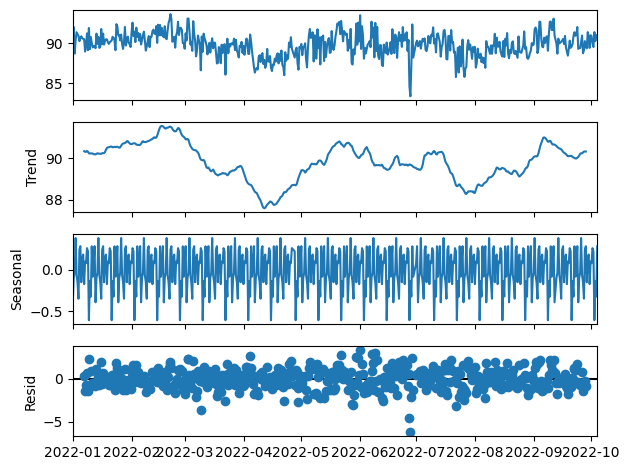

In [879]:
plt.figure(figsize=(15, 20))
result = seasonal_decompose(data_date[~data_date['t13'].isna()], model='additive', period = 24)
result.plot()
plt.show()

Визуально наблюдаем отсутствие тренда и сезонности. Проверим с помощью теста  Дики-Фуллера.

In [880]:
def test_adfuller(dict_):
  for key, value in dict_.items():
      res =  adfuller(value)[1]
      print(key, res)

In [881]:
adfuller(data_date['t13'])[1]

0.004246645768628307

Ряд стационарен.

# Train datasets

In [12]:
def prepare_data(data, missing_value = False):
  train = data
  train["hour"] = train['f12'].dt.hour
  train["dayofweek"] = train['f12'].dt.dayofweek
  train["quarter"] = train['f12'].dt.quarter
  train["month"] = train['f12'].dt.month
  train['dayofyear'] = train['f12'].dt.dayofyear
  train['dayofmonth'] = train['f12'].dt.day
  train['weekofyear'] = train['f12'].dt.isocalendar().week

  train.loc[train['hour'] == 8,'hour'] = 0
  train.loc[train['hour'] == 20,'hour'] = 1
  train = train.set_index('f12')
  train = train.drop(columns = ['DT', 'f2', 'f9'])

  if not missing_value:
    train = train.dropna()

  return train

def norm_data (data):
  norm = StandardScaler()
  f_norm = pd.DataFrame(norm.fit_transform(data.drop(columns = 't13')),columns = data.drop(columns = 't13').columns)


  return f_norm


1-ый набор

In [13]:
train_1 = prepare_data(data_train)

<Axes: xlabel='0', ylabel='0'>

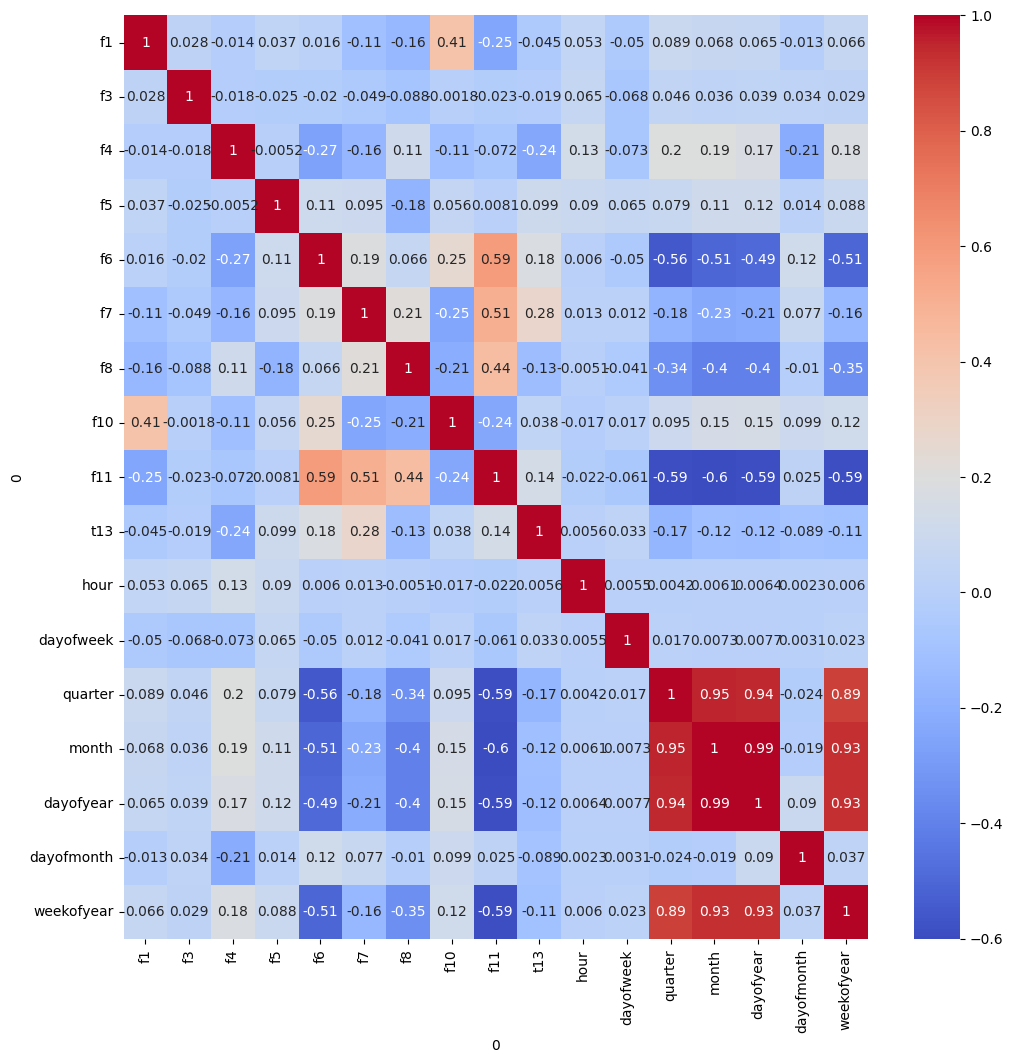

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(train_1.corr(), annot = True, cmap= 'coolwarm')

In [15]:
train_1.head()

,f1,f3,f4,f5,f6,f7,f8,f10,f11,t13,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
f12,,,,,,,,,,,,,,,,,
2021-12-31 20:00:00,-0.478109,2.0,12156.0,0.110,0.096,1.75,0.170,5.71,0.53,90.180705,1,4,4,12,365,31,52
2022-01-01 08:00:00,-0.471832,2.0,12111.0,0.200,0.091,1.77,0.167,4.87,0.55,92.072820,0,5,1,1,1,1,52
2022-01-01 20:00:00,-0.551054,3.0,13173.0,0.240,0.119,1.62,0.196,4.70,0.66,88.721728,1,5,1,1,1,1,52
2022-01-02 08:00:00,-0.565353,4.0,13390.0,0.136,0.110,1.65,0.202,4.78,0.65,90.429851,0,6,1,1,2,2,52
2022-01-02 20:00:00,-0.575714,1.0,13518.0,0.136,0.132,1.73,0.202,4.79,0.66,91.410000,1,6,1,1,2,2,52


Нормализуем данные.

In [16]:
f_norm = norm_data(train_1)

In [17]:
f_norm.head()

,f1,f3,f4,f5,f6,f7,f8,f10,f11,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,0.173343,-0.694646,-0.105293,-1.362165,-1.082755,2.205127,0.886443,0.535980,-0.881917,0.996330,0.488589,2.322807,2.614639,2.806921,1.756313,2.703763
1,0.189615,-0.694646,-0.127569,-0.562218,-1.187363,2.375258,0.812952,-0.711125,-0.756215,-1.003683,0.986328,-1.213407,-1.541005,-1.707425,-1.643002,2.703763
2,-0.015751,0.003852,0.398128,-0.206686,-0.601557,1.099280,1.523368,-0.963515,-0.064859,0.996330,0.986328,-1.213407,-1.541005,-1.707425,-1.643002,2.703763
3,-0.052815,0.702350,0.505544,-1.131069,-0.789852,1.354476,1.670350,-0.844743,-0.127709,-1.003683,1.484067,-1.213407,-1.541005,-1.695023,-1.529692,2.703763
4,-0.079676,-1.393144,0.568905,-1.131069,-0.329576,2.034997,1.670350,-0.829897,-0.064859,0.996330,1.484067,-1.213407,-1.541005,-1.695023,-1.529692,2.703763


2-ой набор

In [18]:
train_2 = prepare_data(data_train,missing_value = True)

In [19]:
train_2.isna().sum()

0
f1            4
f3            0
f4            0
f5            2
f6            3
f7            0
f8            2
f10           1
f11           3
t13           0
hour          0
dayofweek     0
quarter       0
month         0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

Заполним пропуски средним значением.

In [20]:
train_2['f1'].fillna(train_2['f1'].mean(), inplace = True)
train_2['f5'].fillna(train_2['f5'].mean(), inplace = True)
train_2['f6'].fillna(train_2['f6'].mean(), inplace = True)
train_2['f8'].fillna(train_2['f8'].mean(), inplace = True)
train_2['f10'].fillna(train_2['f10'].mean(), inplace = True)
train_2['f11'].fillna(train_2['f11'].mean(), inplace = True)

Нормализуем данные.

In [21]:
f_2_norm = norm_data(train_2)

In [22]:
f_2_norm.head()

,f1,f3,f4,f5,f6,f7,f8,f10,f11,hour,dayofweek,quarter,month,dayofyear,dayofmonth,weekofyear
0,0.173583,-0.696337,-0.104872,-1.366133,-1.084826,2.214133,0.888008,0.540461,-0.874449,0.998180,0.488472,2.318988,2.617203,2.809449,1.758601,2.706576
1,0.189928,-0.696337,-0.127189,-0.563072,-1.189841,2.384929,0.814322,-0.711590,-0.748919,-1.001823,0.986007,-1.220746,-1.547563,-1.713098,-1.635371,2.706576
2,-0.016363,0.002546,0.399490,-0.206156,-0.601759,1.103955,1.526623,-0.964981,-0.058509,0.998180,0.986007,-1.220746,-1.547563,-1.713098,-1.635371,2.706576
3,-0.053595,0.701429,0.507106,-1.134137,-0.790785,1.360150,1.673995,-0.845738,-0.121274,-1.001823,1.483541,-1.220746,-1.547563,-1.700674,-1.522239,2.706576
4,-0.080576,-1.395220,0.570586,-1.134137,-0.328721,2.043336,1.673995,-0.830833,-0.058509,0.998180,1.483541,-1.220746,-1.547563,-1.700674,-1.522239,2.706576


# Test datasets

Анологично проведем подготовку тестовых наборов данных.

In [1018]:
test_1 = prepare_data(data_test,missing_value = True)

In [1019]:
test_1.isna().sum()

0
f1            2
f3            0
f4            0
f5            3
f6            2
f7            0
f8            2
f10           2
f11           2
hour          0
dayofweek     0
quarter       0
month         0
dayofyear     0
dayofmonth    0
weekofyear    0
dtype: int64

In [1020]:
test_1['f1'].fillna(test_1['f1'].mean(), inplace = True)
test_1['f5'].fillna(test_1['f5'].mean(), inplace = True)
test_1['f6'].fillna(test_1['f6'].mean(), inplace = True)
test_1['f8'].fillna(test_1['f8'].mean(), inplace = True)
test_1['f10'].fillna(test_1['f10'].mean(), inplace = True)
test_1['f11'].fillna(test_1['f11'].mean(), inplace = True)

# func

In [35]:
def im(pred,test):
  with plt.style.context('bmh'):
    plt.figure(figsize=(7, 4))
    plt.plot(pd.DataFrame(pred).values, color='blue',label='predict')
    plt.plot(pd.DataFrame(test).values, color='red', linewidth='4',label='real')
    plt.legend()

    plt.tight_layout()

In [36]:
def metrics(x,y,model):
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state= 42)
  model = model
  model.fit(X_train, y_train)
  r2_train = r2_score(y_train, model.predict(X_train))
  r2_test = r2_score(y_test, model.predict(X_test))
  rmse_train = sqrt(mean_squared_error(model.predict(X_train), y_train))
  rmse_test = sqrt(mean_squared_error(model.predict(X_test), y_test))
  pred = model.predict(X_test)
  return r2_train, r2_test, rmse_train, rmse_test

In [37]:
def res_pred(x,y,model):
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state= 42)
  model = model
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  return y_test, pred

def res_test(x,y,model,test):
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1,random_state= 42)
  model = model
  model.fit(X_train, y_train)
  pred = model.predict(test)
  return pred

# lr

In [845]:
f = ['f1', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f10', 'f11', 'hour',
       'dayofweek', 'quarter', 'month', 'dayofyear', 'dayofmonth',
       'weekofyear']

In [846]:
res = pd.DataFrame({
              'Сырые данные без пропусков':metrics(train_1[f],train_1['t13'],LinearRegression()),
              'Сырые нормализованные данные без пропусков':metrics(f_norm[f],train_1['t13'],LinearRegression()),
              'Обработанные данные':metrics(train_2[f],train_2['t13'],LinearRegression()),
              'Нормализованные обработанные данные': metrics(f_2_norm[f],train_2['t13'],LinearRegression())},
             index = ['r2_train','r2_test','rmse_train','rmse_test'])
res.T

,r2_train,r2_test,rmse_train,rmse_test
Сырые данные без пропусков,0.272216,0.025341,1.253367,1.583761
Сырые нормализованные данные без пропусков,0.272216,0.025341,1.253367,1.583761
Обработанные данные,0.270942,-0.015440,1.267970,1.486095
Нормализованные обработанные данные,0.270942,-0.015440,1.267970,1.486095


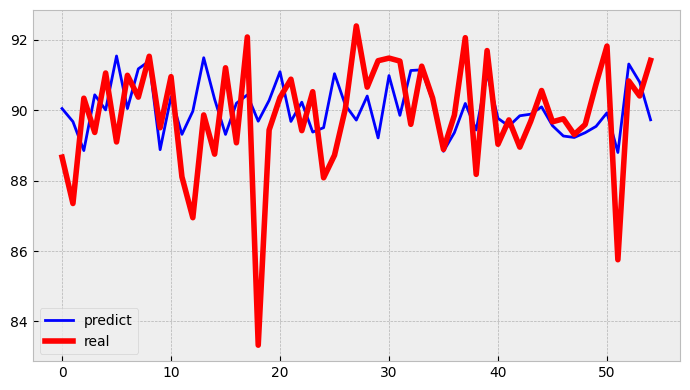

In [847]:
y_test, pred = res_pred(train_1.drop(columns = 't13'),train_1['t13'],LinearRegression())
im(pred,y_test)

# Polinom lr

In [848]:
polynomial_features= PolynomialFeatures(degree=4)

In [849]:
x_poly_train_1 = polynomial_features.fit_transform(train_1[f])
x_poly_train_1_norm = polynomial_features.fit_transform(f_norm[f])
x_poly_train_2 = polynomial_features.fit_transform(train_2[f])
x_poly_train_2_norm = polynomial_features.fit_transform(f_2_norm[f])

In [850]:
res = pd.DataFrame({
              'Сырые данные без пропусков':metrics(x_poly_train_1,train_1['t13'],LinearRegression()),
              'Сырые нормализованные данные без пропусков':metrics(x_poly_train_1_norm,train_1['t13'],LinearRegression()),
              'Обработанные данные':metrics(x_poly_train_2,train_2['t13'],LinearRegression()),
              'Нормализованные обработанные данные': metrics(x_poly_train_2_norm,train_2['t13'],LinearRegression())},
             index = ['r2_train','r2_test','rmse_train','rmse_test'])
res.T

,r2_train,r2_test,rmse_train,rmse_test
Сырые данные без пропусков,0.995049,-177.505285,1.033740e-01,21.433282
Сырые нормализованные данные без пропусков,1.000000,-1.603624,1.609700e-13,2.588524
Обработанные данные,0.954966,-60.450005,3.151356e-01,11.560600
Нормализованные обработанные данные,1.000000,-4.600236,8.205720e-14,3.489977


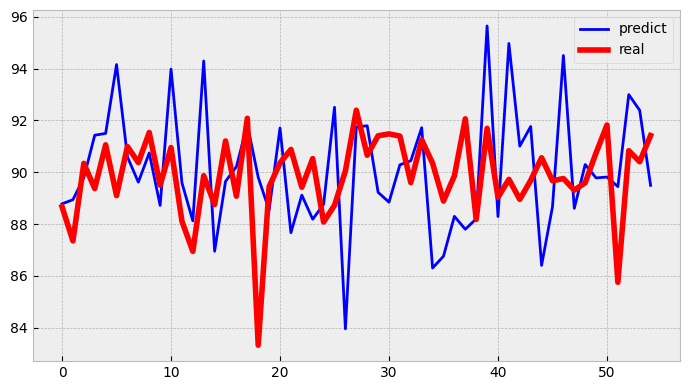

In [851]:
y_test, pred = res_pred(x_poly_train_1_norm,train_1['t13'],LinearRegression())
im(pred,y_test)

# Дерево решений

In [852]:
X_train, X_test, y_train, y_test = train_test_split(train_1[f],train_1['t13'], test_size=0.2, random_state= 42)

In [853]:
for i in range(1, 20):
  model_tree = DecisionTreeRegressor(max_depth = i, random_state = 42)
  model_tree.fit(X_train, y_train)
  print(f'depth = {i}, score = {model_tree.score(X_test, y_test)}')

depth = 1, score = 0.1480543799123224
depth = 2, score = 0.19814621718159997
depth = 3, score = 0.17890303584180356
depth = 4, score = 0.18233368196853772
depth = 5, score = 0.21912351314328904
depth = 6, score = 0.1801247609333828
depth = 7, score = 0.18351662155503368
depth = 8, score = 0.14542260951776398
depth = 9, score = 0.01779355360190671
depth = 10, score = -0.0413509720737979
depth = 11, score = 0.03159903226436522
depth = 12, score = -0.04817876494951312
depth = 13, score = -0.06975372598034779
depth = 14, score = -0.09645628424192099
depth = 15, score = -0.13262420180342427
depth = 16, score = -0.08384492168076108
depth = 17, score = -0.06570300072510626
depth = 18, score = -0.056279716558885085
depth = 19, score = -0.05116588353227325


In [854]:
for i in range(1, 50):
  model_tree = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = i, random_state = 42)
  model_tree.fit(X_train, y_train)
  print(f'min_samples_leaf = {i}, score = {model_tree.score(X_test, y_test)}')

min_samples_leaf = 1, score = 0.18351662155503368
min_samples_leaf = 2, score = 0.15608294013646495
min_samples_leaf = 3, score = 0.15725840081473152
min_samples_leaf = 4, score = 0.1467108695806454
min_samples_leaf = 5, score = 0.17828707314752956
min_samples_leaf = 6, score = 0.164441575059308
min_samples_leaf = 7, score = 0.129164304807177
min_samples_leaf = 8, score = -0.06298161707802352
min_samples_leaf = 9, score = -0.03192693236644284
min_samples_leaf = 10, score = 0.020963096297280104
min_samples_leaf = 11, score = 0.09536151630430945
min_samples_leaf = 12, score = 0.1259471474102991
min_samples_leaf = 13, score = 0.1414504801794032
min_samples_leaf = 14, score = 0.14671515678584368
min_samples_leaf = 15, score = 0.14671515678584368
min_samples_leaf = 16, score = 0.1324798095085583
min_samples_leaf = 17, score = 0.1383831682363903
min_samples_leaf = 18, score = 0.135999864243195
min_samples_leaf = 19, score = 0.1347574983377574
min_samples_leaf = 20, score = 0.1252193549347389

In [855]:
model_tree = DecisionTreeRegressor(max_depth = 7, min_samples_leaf = 1, random_state = 42)

In [856]:
res = pd.DataFrame({
              'Сырые данные без пропусков':metrics(train_1[f],train_1['t13'], model_tree),
              'Сырые нормализованные данные без пропусков':metrics(f_norm[f],train_1['t13'],model_tree),
              'Обработанные данные':metrics(train_2[f],train_2['t13'],model_tree),
              'Нормализованные обработанные данные': metrics(f_2_norm[f],train_2['t13'],model_tree)},
             index = ['r2_train','r2_test','rmse_train','rmse_test'])
res.T

,r2_train,r2_test,rmse_train,rmse_test
Сырые данные без пропусков,0.742924,-0.038086,0.744917,1.634481
Сырые нормализованные данные без пропусков,0.742924,-0.038086,0.744917,1.634481
Обработанные данные,0.699746,-0.533374,0.813715,1.826180
Нормализованные обработанные данные,0.699746,-0.533374,0.813715,1.826180


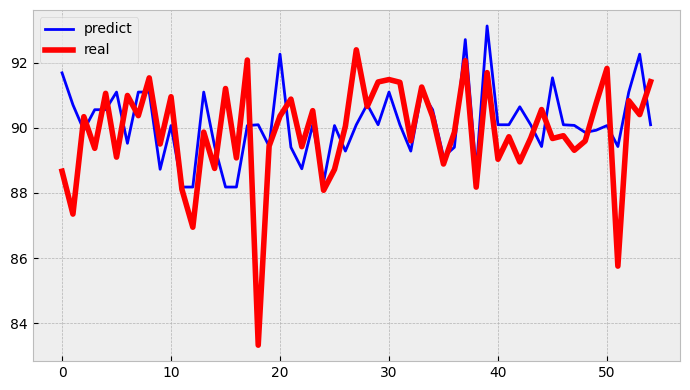

In [857]:
y_test, pred = res_pred(f_norm,train_1['t13'],model_tree)
im(pred,y_test)

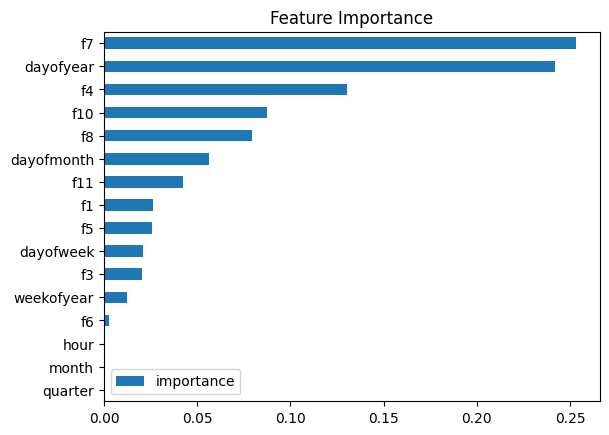

In [858]:
fi = pd.DataFrame(data=model_tree.feature_importances_,
             index=model_tree.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# XGBRegressor

In [1384]:
f = [
    # 'f3',
    'f4',
    # 'f5',
    # 'f6',
    'f7',
    'f8',
    # 'f10',
    'f11',
    # 'hour',
       'dayofweek',
    'quarter',
    'month',
    # 'dayofyear',
    'dayofmonth',
       'weekofyear'
    ]

In [1385]:
reg = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    subsample=0.5,
    colsample_bytree=1,
    max_depth=6
)

In [1386]:
res = pd.DataFrame({
              'Сырые данные без пропусков':metrics(train_1[f],train_1['t13'], reg),
              'Сырые нормализованные данные без пропусков':metrics(f_norm[f],train_1['t13'],reg),
              'Обработанные данные':metrics(train_2[f],train_2['t13'],reg),
              'Нормализованные обработанные данные': metrics(f_2_norm[f],train_2['t13'],reg)},
             index = ['r2_train','r2_test','rmse_train','rmse_test'])
res.T

,r2_train,r2_test,rmse_train,rmse_test
Сырые данные без пропусков,0.999985,0.439079,0.005718,1.201472
Сырые нормализованные данные без пропусков,0.999985,0.439079,0.005718,1.201472
Обработанные данные,0.999986,0.295485,0.005654,1.237840
Нормализованные обработанные данные,0.999986,0.295485,0.005654,1.237840


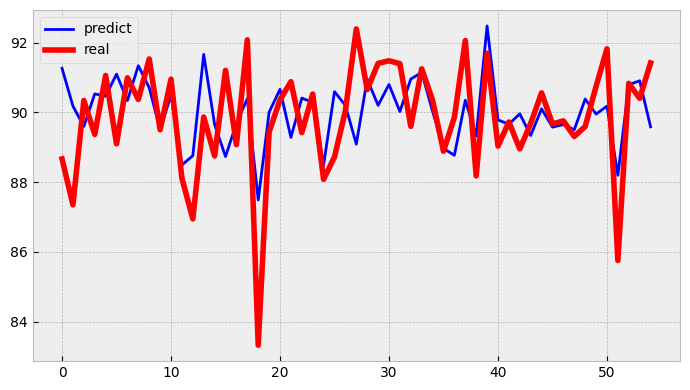

In [1387]:
y_test, pred = res_pred(f_norm,train_1['t13'],reg)
im(pred,y_test)

In [1388]:
reg_2 = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    subsample=0.5,
    colsample_bytree=1,
    max_depth=5,

)

In [1389]:
reg_2.fit(train_1[f],train_1['t13'])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [1395]:
pd.DataFrame([test_1.index,reg_2.predict(test_1[f])]).T
# .to_csv('results.csv')

,0,1
0,2022-10-04 20:00:00,90.416206
1,2022-10-05 08:00:00,90.67868
2,2022-10-05 20:00:00,90.314972
3,2022-10-06 08:00:00,91.475464
4,2022-10-06 20:00:00,90.94117
...,...,...
93,2022-11-20 08:00:00,89.531319
94,2022-11-20 20:00:00,90.400833
95,2022-11-21 08:00:00,89.835457
96,2022-11-21 20:00:00,90.638008


# RandomForestRegressor

In [866]:
RF = RandomForestRegressor(max_depth=10,random_state=42)

In [867]:
res = pd.DataFrame({
              'Сырые данные без пропусков':metrics(train_1[f],train_1['t13'], RF),
              'Сырые нормализованные данные без пропусков':metrics(f_norm[f],train_1['t13'],RF),
              'Обработанные данные':metrics(train_2[f],train_2['t13'],RF),
              'Нормализованные обработанные данные': metrics(f_2_norm[f],train_2['t13'],RF)},
             index = ['r2_train','r2_test','rmse_train','rmse_test'])
res.T

,r2_train,r2_test,rmse_train,rmse_test
Сырые данные без пропусков,0.866105,0.216907,0.537599,1.419612
Сырые нормализованные данные без пропусков,0.866792,0.217829,0.536218,1.418776
Обработанные данные,0.874792,0.122122,0.525467,1.381772
Нормализованные обработанные данные,0.874661,0.117629,0.525740,1.385304


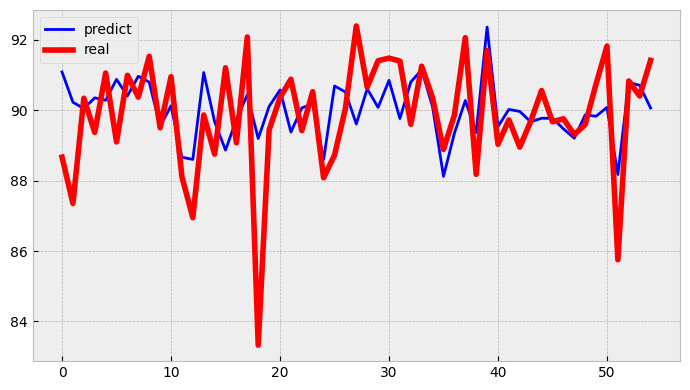

In [868]:
y_test, pred = res_pred(f_norm,train_1['t13'],RF)
im(pred,y_test)

In [869]:
RF.predict(test_1)

array([90.56188756, 90.51902761, 90.48803259, 90.88564532, 90.51778355,
       90.51902761, 90.44841327, 90.83616675, 90.8752476 , 91.05292845,
       90.89289457, 90.5803898 , 90.89079097, 91.17523285, 90.56064351,
       90.86482221, 91.0730236 , 90.83616675, 91.14424617, 90.87481306,
       90.87356901, 90.50677506, 90.86423911, 90.50677506, 91.10109597,
       90.90828938, 91.04920498, 91.07399333, 91.07399333, 90.83616675,
       90.50677506, 90.44683538, 90.28077606, 90.4787027 , 90.50801912,
       90.51132083, 90.50677506, 90.4787027 , 91.16266155, 91.08547052,
       91.21736651, 91.18948177, 91.20588931, 91.21658442, 91.14347025,
       91.13431658, 91.03554109, 91.08217727, 91.15069198, 91.0730236 ,
       91.07426766, 90.48785636, 90.24177839, 90.33581453, 90.35946136,
       90.3502998 , 90.33252686, 90.41848608, 90.50677506, 90.50801912,
       90.22432802, 90.24861197, 90.24964553, 90.21625038, 90.21625038,
       90.24177839, 91.0730236 , 91.15398524, 90.36772207, 90.27

# LSTM


In [23]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [24]:
lstm_data = data_train.dropna()
lstm_data = lstm_data.set_index('DT')

In [25]:
f = [
    'f1',
    'f2',
    'f3',
    'f4',
    'f5',
    'f6',
    'f7',
    'f8',
    'f9',
    'f10',
    'f11'
    ]

In [26]:
y_lstm_data = lstm_data['t13']
lstm_data = lstm_data[f]

In [27]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [28]:
scaler_x = MinMaxScaler(feature_range=(0, 1))
dataset_x = scaler_x.fit_transform(lstm_data)
scaler_y = MinMaxScaler(feature_range=(0, 1))
dataset_y = scaler_y.fit_transform(pd.DataFrame(y_lstm_data))

In [29]:
time_steps = 1
X, y = create_dataset(pd.DataFrame(dataset_x), pd.DataFrame(dataset_y), time_steps)

In [30]:
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [31]:
model = Sequential()

model.add(LSTM(units=5, input_shape=(1,len(f))))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
488/488 - 3s - loss: 0.0953 - 3s/epoch - 6ms/step
Epoch 2/50
488/488 - 1s - loss: 0.0392 - 849ms/epoch - 2ms/step
Epoch 3/50
488/488 - 1s - loss: 0.0299 - 846ms/epoch - 2ms/step
Epoch 4/50
488/488 - 1s - loss: 0.0261 - 818ms/epoch - 2ms/step
Epoch 5/50
488/488 - 1s - loss: 0.0258 - 823ms/epoch - 2ms/step
Epoch 6/50
488/488 - 1s - loss: 0.0244 - 828ms/epoch - 2ms/step
Epoch 7/50
488/488 - 1s - loss: 0.0223 - 815ms/epoch - 2ms/step
Epoch 8/50
488/488 - 1s - loss: 0.0211 - 876ms/epoch - 2ms/step
Epoch 9/50
488/488 - 1s - loss: 0.0212 - 1s/epoch - 3ms/step
Epoch 10/50
488/488 - 1s - loss: 0.0204 - 1s/epoch - 2ms/step
Epoch 11/50
488/488 - 1s - loss: 0.0212 - 835ms/epoch - 2ms/step
Epoch 12/50
488/488 - 1s - loss: 0.0200 - 871ms/epoch - 2ms/step
Epoch 13/50
488/488 - 1s - loss: 0.0195 - 872ms/epoch - 2ms/step
Epoch 14/50
488/488 - 1s - loss: 0.0191 - 880ms/epoch - 2ms/step
Epoch 15/50
488/488 - 1s - loss: 0.0191 - 862ms/epoch - 2ms/step
Epoch 16/50
488/488 - 1s - loss: 0.0191 - 8

In [32]:
predictions = model.predict(X_test)
predictions = scaler_y.inverse_transform(predictions)
y_test = scaler_y.inverse_transform(y_test)

2/2 [==============================] - 1s 6ms/step


In [33]:
print(f'RMSE : {mean_squared_error(predictions, y_test,squared=False)}')
print(f'R2 : {r2_score(y_test,predictions)}')

RMSE : 0.9745775839959839
R2 : 0.1026757575429813


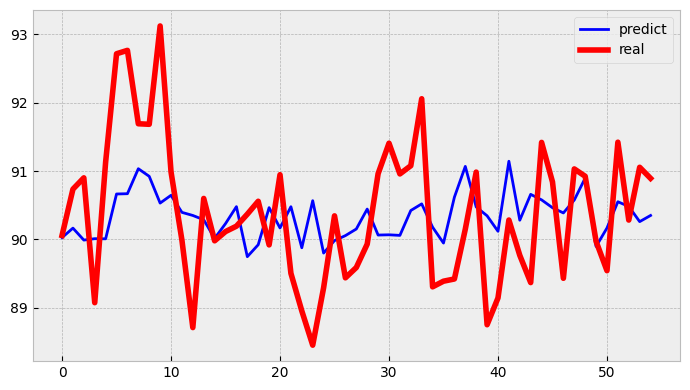

In [38]:
im(predictions, y_test)